# Crop Yield Prediction: Random Forest

I am going to use a **Random Forest** model to predict crop yields this time. I will try to improve the accuracy using a hyperparameter tuner called **Optuna**, just like before.

**Here is the plan:**
1.  **Setup:** Load the cleaned data and choose a crop (I am sticking with **Rice**).
2.  **Split:** Divide the data by year (Train, Validation, Test).
3.  **Initial Model:** Train a simple Random Forest with default settings.
4.  **Tuned Model:** Use Optuna to find the best tree depth and split criteria.
5.  **Evaluation:** Compare the performance of the Initial and Tuned models.

In [83]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optuna visualization tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Making the plots look nice with a standard setup.
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Data Prep and Crop Choice
I am loading the cleaned dataset (Part 3 parquet file) and setting the prediction target to **Rice**. I will also clean up any rows that are missing the target yield.

In [84]:
# Loading the parquet file.
df = pd.read_parquet('Parquet/XY_v3.parquet')

# Checking what crops we have available.
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("Crops available:", available_crops)
print("-" * 30)

# --- SETTING THE CROP HERE ---
CHOSEN_CROP = 'rice' 
# -----------------------------

TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y' 

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found. Please check spelling.")

print(f"Target Variable: {TARGET_COL}")

# Dropping rows where the target is missing because I cannot train on those.
df_model = df.dropna(subset=[TARGET_COL])

print(f"Rows ready for training: {len(df_model)}")

Crops available: ['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
------------------------------
Target Variable: Y_rice
Rows ready for training: 4687


### 2. Splitting the Data
Since this is **time-series data**, I need to split the data by year. This ensures the model is not predicting an earlier year using data it would not have known yet.

* **Train:** Data before 2014.
* **Validation:** Data from 2014 to 2018 (used for tuning).
* **Test:** Data from 2019 onwards (used for the final score).

In [85]:
# Cleaning up and removing lag features that belong to other crops.
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# Defining my X (features).
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

print(f"Number of features: {len(feature_cols)}")
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# Training set.
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# Validation set.
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# Test set.
mask_test = df_model['year'] >= VAL_END_YEAR
X_test = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

print(f"\nTrain size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")

Number of features: 17


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude



Train size: 3547
Val size:   570
Test size:  570


In [86]:
X_train.head()

,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude
0,1982,2241.4,2207.10,2181.766667,325.32,154.391016,59.402942,NaN,NaN,NaN,11.699167,-33.899342,-60.110408,NaN,5.778887,34.53,69.17
1,1983,2199.4,2220.40,2204.533333,373.54,186.787027,72.870980,NaN,NaN,NaN,10.650833,-42.640609,-60.922614,NaN,6.672946,34.53,69.17
2,1984,2258.1,2228.75,2232.966667,273.25,211.709895,-21.830163,NaN,NaN,NaN,11.383333,-46.025539,-55.929678,NaN,7.152971,34.53,69.17
3,1985,2241.6,2249.85,2233.033333,196.10,96.438281,33.467341,19.215833,-13.475498,-51.480910,11.888333,-39.599910,-69.677748,NaN,9.178255,34.53,69.17
4,1986,2248.2,2244.90,2249.300000,155.09,67.530475,38.964517,18.741667,-12.861915,-47.249218,12.511667,-31.144849,-60.631870,NaN,9.224020,34.53,69.17


### 3. Initial Model
I am setting up a standard Random Forest model first. I just want to see what kind of baseline score I can get before tuning anything.

In [87]:
# --- Regularized Random Forest ---
model_reg = RandomForestRegressor(
    n_estimators=100,        # best number of trees
    max_depth=16,            # optimal tree depth
    min_samples_split=2,     # minimum samples to split
    min_samples_leaf=5,      # minimum samples per leaf
    max_features='log2',     # features considered per split
    random_state=42,
    n_jobs=-1
)

# Fit model
model_reg.fit(X_train, y_train)

# Predictions
y_pred_train = model_reg.predict(X_train)
y_pred_val = model_reg.predict(X_val)
y_pred_test = model_reg.predict(X_test)

# Compute metrics
metrics_table = pd.DataFrame({
    'Metric': ['RMSE', 'R²'],
    'Train': [np.sqrt(mean_squared_error(y_train, y_pred_train)), r2_score(y_train, y_pred_train)],
    'Validation': [np.sqrt(mean_squared_error(y_val, y_pred_val)), r2_score(y_val, y_pred_val)],
    'Test': [np.sqrt(mean_squared_error(y_test, y_pred_test)), r2_score(y_test, y_pred_test)]
}).round(4)

print(metrics_table)


  Metric     Train  Validation      Test
0   RMSE  366.3277    527.1895  509.0459
1     R²    0.9610      0.9421    0.9476


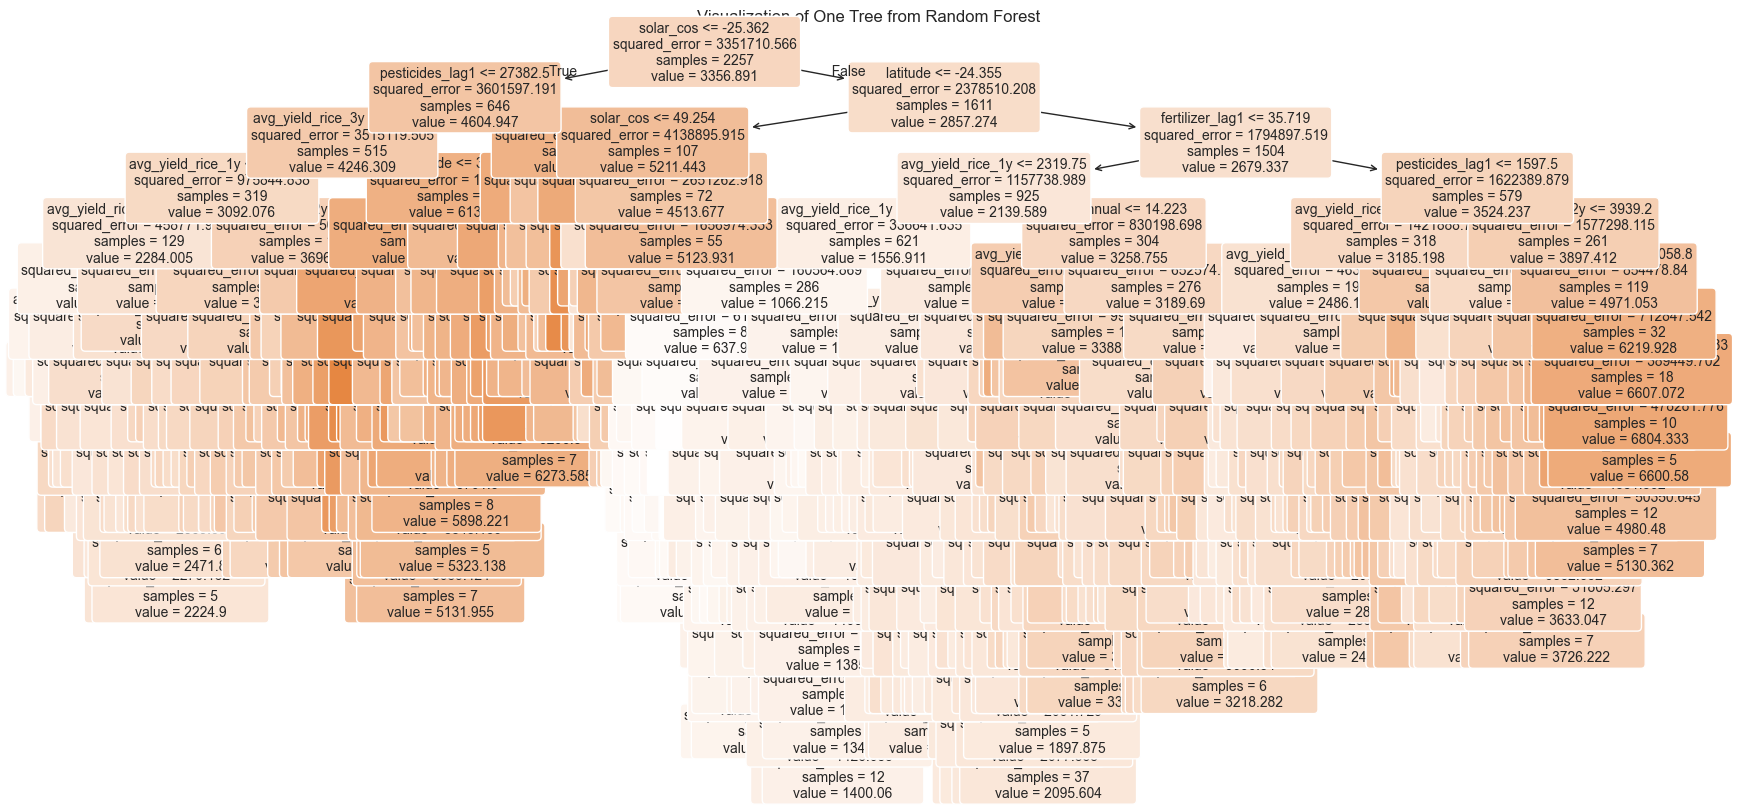

In [88]:
from sklearn.tree import plot_tree


# Choose one tree from the Random Forest
tree = model_reg.estimators_[0]  # first tree

plt.figure(figsize=(20,10))
plot_tree(
    tree,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Visualization of One Tree from Random Forest")
plt.show()


### 4. Tuning with Optuna
The initial model seems okay, but I think I can improve the score by finding better hyperparameter settings. I will run **Optuna** for 20 trials to try different tree depths and split criteria.

In [89]:
# Defining the objective function for Optuna.
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestRegressor(**params)
    
    # Training on the train set and evaluating on the validation set.
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

# Running the study.
study_name = f'{CHOSEN_CROP}_rf_optimization'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=100)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-12-09 01:18:44,687] A new study created in memory with name: rice_rf_optimization
[I 2025-12-09 01:18:45,599] Trial 0 finished with value: 536.2860055739708 and parameters: {'n_estimators': 236, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 536.2860055739708.
[I 2025-12-09 01:18:46,062] Trial 1 finished with value: 532.9975421443173 and parameters: {'n_estimators': 286, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 532.9975421443173.
[I 2025-12-09 01:18:46,435] Trial 2 finished with value: 534.6078648978253 and parameters: {'n_estimators': 189, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 532.9975421443173.
[I 2025-12-09 01:18:46,839] Trial 3 finished with value: 536.0500907165972 and parameters: {'n_estimators': 225, 'max_depth': 19, 'min_samples_split': 18, 'min_sample


Best Parameters found:
{'n_estimators': 139, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}


### 5. Visualization
These plots show how the tuning went and which parameters were most important. It looks like Optuna found a few good combinations.

In [90]:
# Optimization history.
fig = plot_optimization_history(study)
fig.update_layout(title='Optimization History', width=900, height=500)
fig.show()

# Parameter Importance.
try:
    fig = plot_param_importances(study)
    fig.update_layout(title='Hyperparameter Importance', width=900, height=500)
    fig.show()
except Exception as e:
    print("Could not plot importance:", e)

### 6. Final Model
I am training the final version now. Since tuning is finished, I can **combine the Training and Validation sets** to give the Random Forest as much historical data as possible. Then I will test it on the unseen Test set.

In [91]:
# Merging train and val for the final model training.
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Setting up params (reusing best params found by Optuna).
best_params = study.best_params
best_params['n_estimators'] = 150  # Giving it a few more trees for the final run.
best_params['random_state'] = 42
best_params['n_jobs'] = -1

final_model = RandomForestRegressor(**best_params)

# Training on the full history.
final_model.fit(X_train_full, y_train_full)

# Train predictions.
y_pred_final_train = final_model.predict(X_train)
rmse_final_train = np.sqrt(mean_squared_error(y_train, y_pred_final_train))
r2_final_train = r2_score(y_train, y_pred_final_train)

# Validation predictions.
y_pred_final_val = final_model.predict(X_val)
rmse_final_val = np.sqrt(mean_squared_error(y_val, y_pred_final_val))
r2_final_val = r2_score(y_val, y_pred_final_val)

# Test predictions.
y_pred_final_test = final_model.predict(X_test)
rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)

# --- Create table ---
metrics_table_final = pd.DataFrame({
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_final_train, r2_final_train],
    'Validation': [rmse_final_val, r2_final_val],
    'Test': [rmse_final_test, r2_final_test]
})

# Rounding for readability.
metrics_table_final = metrics_table_final.round(4)

print(metrics_table_final)

  Metric     Train  Validation      Test
0   RMSE  365.1595    364.5421  491.6196
1     R²    0.9612      0.9723    0.9511


### 7. Results Comparison
Let's see if the tuning actually helped. I am comparing the RMSE of the Initial Model (default settings) vs the Tuned Model (best settings found by Optuna).

--- Final Test Set Results ---
Initial Model: RMSE=554.59, R2=0.9378
Tuned Model:   RMSE=491.62, R2=0.9511
Improvement:   11.35%


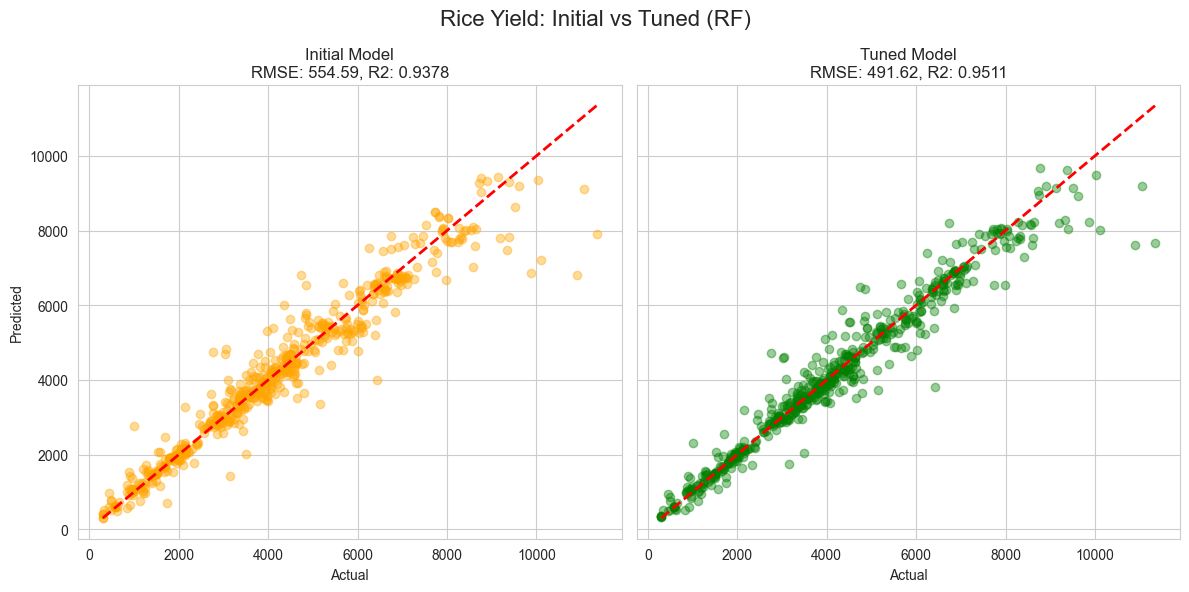

In [92]:
# Calculating improvement of Tuned Model over the Initial Model.
imp_final = (rmse_init_test - rmse_final_test) / rmse_init_test * 100

print("--- Final Test Set Results ---")
print(f"Initial Model: RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned Model:   RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f}")
print(f"Improvement:   {imp_final:.2f}%")

# --- PLOTTING ---
# Plotting the two models side-by-side (Initial and Tuned).
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Setting axis limits so they match on both plots.
all_preds = np.concatenate([y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# Initial Model Plot.
axes[0].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(
    f'Initial Model\nRMSE: {rmse_init_test:.2f}, R2: {r2_init_test:.4f}'
)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Tuned Model Plot.
axes[1].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(
    f'Tuned Model\nRMSE: {rmse_final_test:.2f}, R2: {r2_final_test:.4f}'
)
axes[1].set_xlabel('Actual')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Initial vs Tuned (RF)', fontsize=16)
plt.tight_layout()
plt.show()

### 8. Trend Analysis
I will visualize how the model performed over the years. This helps check if it captures the general ups and downs.

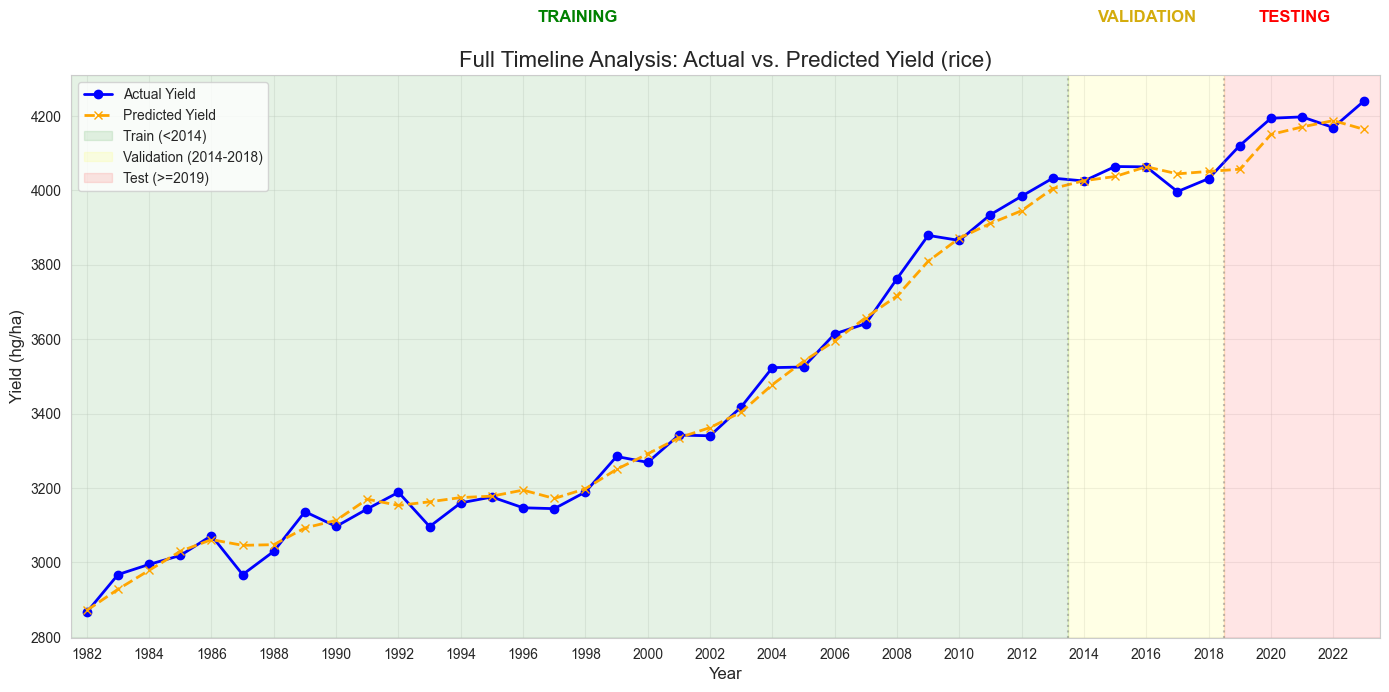

In [93]:
# 1. Predictions.
all_predictions = final_model.predict(df_model[feature_cols])

# 2. Building DataFrame.
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})

# 3. Aggregating yearly.
yearly_trend = df_full_trend.groupby('Year').mean()

# 4. Plot.
plt.figure(figsize=(14, 7))

# Plotting lines.
plt.plot(yearly_trend.index, yearly_trend['Actual'],
         marker='o', label='Actual Yield', linewidth=2, color='blue')

plt.plot(yearly_trend.index, yearly_trend['Predicted'],
         marker='x', linestyle='--', label='Predicted Yield', linewidth=2, color='orange')

# --- Boundaries ---
MIN_YEAR = yearly_trend.index.min()
MAX_YEAR = yearly_trend.index.max()

train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Shaded Regions ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1,
            label=f'Train (<{TRAIN_END_YEAR})')

plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1,
            label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1})')

plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1,
            label=f'Test (>={VAL_END_YEAR})')

# --- Split Lines ---
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# --- Labels ---
y_max = yearly_trend['Actual'].max()
text_y = y_max * 1.05

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING',
         ha='center', fontsize=12, fontweight='bold', color='green')

plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION',
         ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')

plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING',
         ha='center', fontsize=12, fontweight='bold', color='red')

# --- Final Styling ---
plt.title(f'Full Timeline Analysis: Actual vs. Predicted Yield ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

plt.tight_layout()
plt.show()


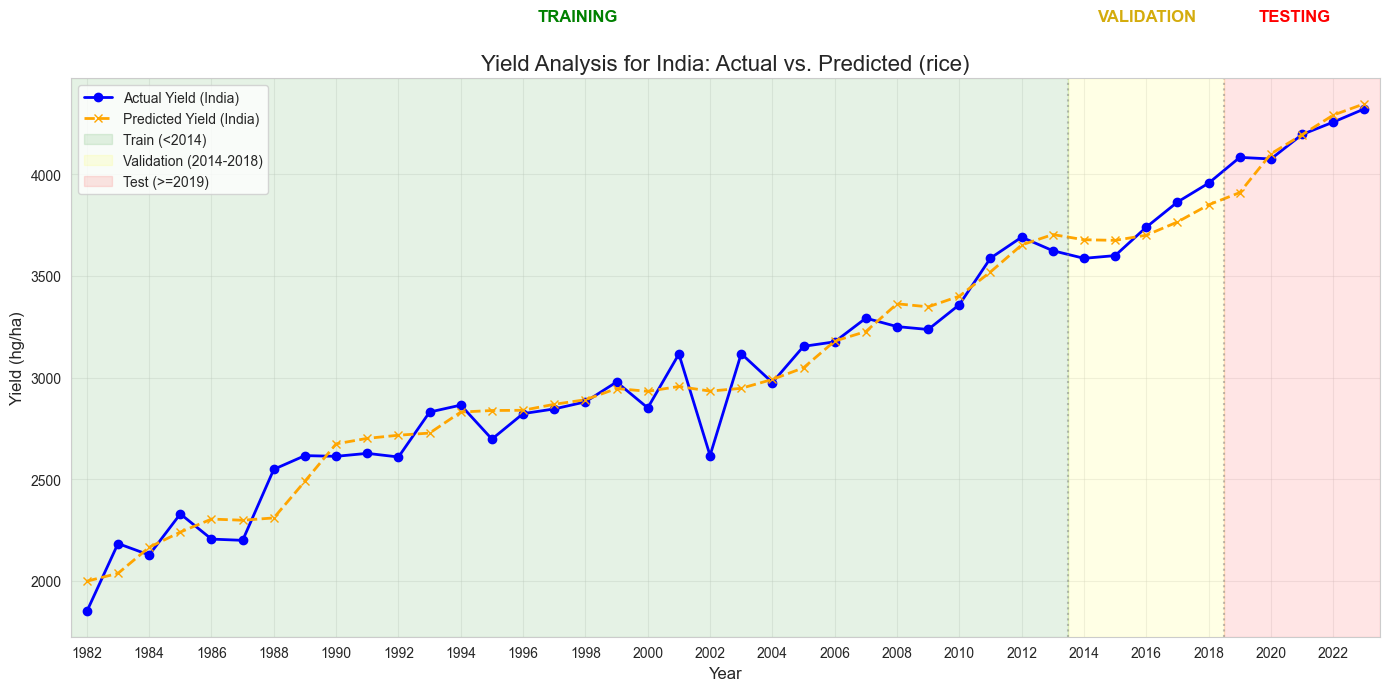

In [94]:
# --- Adding country column ---
df_full_trend['Area'] = df_model['area']

# --- Country-specific trend ---
TARGET_COUNTRY = "India"
df_country = df_full_trend[df_full_trend['Area'] == TARGET_COUNTRY]
country_trend = df_country.groupby('Year')[['Actual', 'Predicted']].mean()

# --- Plot ---
plt.figure(figsize=(14, 7))

# Country lines.
plt.plot(country_trend.index, country_trend['Actual'],
         marker='o', label=f'Actual Yield ({TARGET_COUNTRY})', linewidth=2, color='blue')
plt.plot(country_trend.index, country_trend['Predicted'],
         marker='x', linestyle='--', label=f'Predicted Yield ({TARGET_COUNTRY})', linewidth=2, color='orange')

# --- Boundaries ---
MIN_YEAR = country_trend.index.min()
MAX_YEAR = country_trend.index.max()
train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Shaded regions ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1, label=f'Train (<{TRAIN_END_YEAR})')
plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR-1})')
plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1, label=f'Test (>={VAL_END_YEAR})')

# --- Split lines ---
plt.axvline(train_boundary, color='grey', linestyle=':', alpha=0.5)
plt.axvline(val_boundary, color='grey', linestyle=':', alpha=0.5)

# --- Labels ---
y_max = country_trend['Actual'].max()
text_y = y_max * 1.1

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING', ha='center', fontsize=12, fontweight='bold', color='green')
plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION', ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')
plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING', ha='center', fontsize=12, fontweight='bold', color='red')

# --- Final styling ---
plt.title(f'Yield Analysis for {TARGET_COUNTRY}: Actual vs. Predicted ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)

plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)
plt.tight_layout()
plt.show()


### 9. Geographic Error Map
I want to see where the model makes the biggest mistakes. I will map the error (RMSPE) by country.

In [95]:
import numpy as np
import pandas as pd
import plotly.express as px

# --- 1. Prepare the test DataFrame ---
mask_test = df_model['year'] >= VAL_END_YEAR
test_context = df_model[mask_test][['area', 'year']]

comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_final_test
})

# Joining back country info.
comparison_df = comparison_df.join(test_context)

# --- 2. Filter only the latest year per country ---
latest_year = comparison_df.groupby('area')['year'].transform('max')
comparison_df_latest = comparison_df[comparison_df['year'] == latest_year]

print(comparison_df_latest.head())

     Actual_Value  Predicted_Value         area  year
41         4627.9      4592.310084  Afghanistan  2023
125        1790.3      1770.417586      Algeria  2023
167        1172.1      1245.360918       Angola  2023
251        6723.7      6841.661153    Argentina  2023
325        9516.2      9141.739273    Australia  2023


In [96]:
import plotly.express as px

# Fixing country names for Plotly.
comparison_df['area'] = comparison_df_latest['area'].replace({
    'United_States_of_America': 'United States',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'China, mainland': 'China',
    'Republic_of_Korea': 'South Korea'
})

# Calculating squared error.
comparison_df['Squared_Error'] = (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) ** 2

# Calculating percentage error squared for RMSPE.
comparison_df['Error_Pct'] = ((comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / (comparison_df['Actual_Value'] + 1e-6)) ** 2

# Aggregating by country.
map_data = comparison_df.groupby('area').agg(
    RMSPE=('Error_Pct', lambda x: np.sqrt(x.mean()) * 100),
    RMSE=('Squared_Error', lambda x: np.sqrt(x.mean())),
    Actual_Mean=('Actual_Value', 'mean'),
    Predicted_Mean=('Predicted_Value', 'mean')
).reset_index()

map_data.rename(columns={'area':'Country'}, inplace=True)

# Plotting with hover data including RMSE.
fig = px.choropleth(
    map_data,
    locations='Country',
    locationmode='country names',
    color='RMSPE',
    color_continuous_scale=['green', 'red'],
    range_color=[0, 50],
    title='Prediction Error by Country (RMSPE)',
    hover_data={
        'RMSPE': ':.2f',
        'RMSE': ':.2f',
        'Actual_Mean': ':.2f',
        'Predicted_Mean': ':.2f'
    }
)

fig.show()


C:\Users\PavinP\AppData\Local\Temp\ipykernel_28896\1488517086.py:30: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### 10. Feature Importance
Finally, let's see which features the model thought were the most useful.


--- Top 20 Most Important Features (Text Report) ---
              Feature  Importance
0   avg_yield_rice_2y    0.330225
1   avg_yield_rice_1y    0.268145
2   avg_yield_rice_3y    0.224045
3     fertilizer_lag1    0.045999
4     pesticides_lag1    0.026367
5           solar_cos    0.018944
6            latitude    0.018729
7         temp_annual    0.016893
8        solar_annual    0.010543
9            temp_cos    0.009297
10           temp_sin    0.007818
11          longitude    0.006525
12        rain_annual    0.005309
13               year    0.003240
14          solar_sin    0.003024
15           rain_sin    0.002611
16           rain_cos    0.002285


C:\Users\PavinP\AppData\Local\Temp\ipykernel_28896\4006638654.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




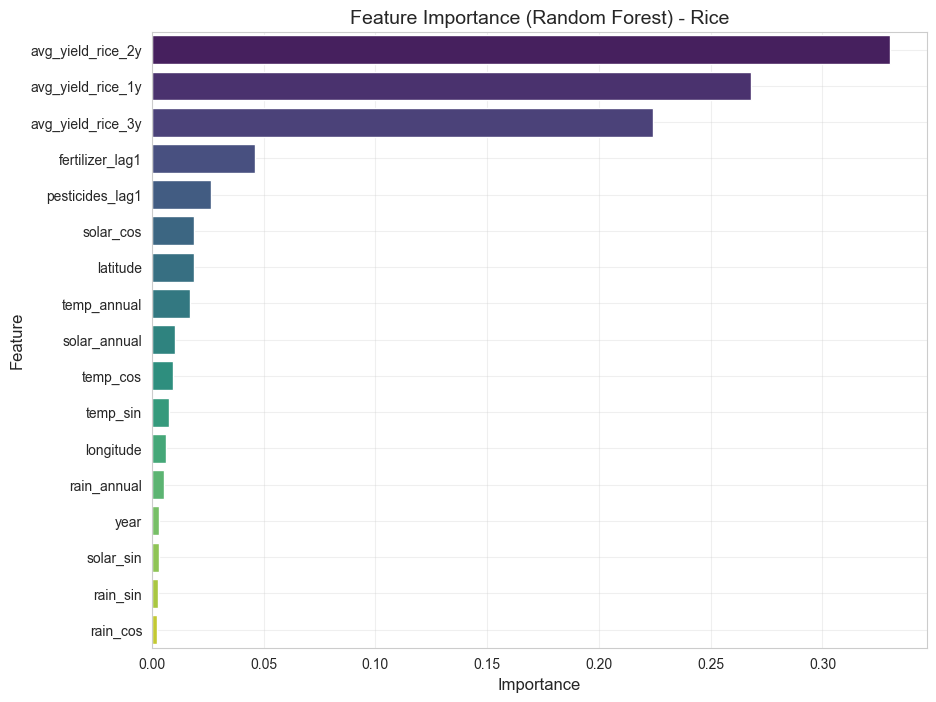

In [97]:
# --- FEATURE IMPORTANCE: PLOT & TEXT ---

# 1. Extract feature importances.
importances = final_model.feature_importances_
feature_names = final_model.feature_names_in_

# 2. Create a DataFrame to display as text.
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort by importance.
fi_df = fi_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 4. PRINT TEXT: Display the Top 20 features.
print("\n--- Top 20 Most Important Features (Text Report) ---")
print(fi_df.head(20))

# 5. PLOT GRAPH: Using seaborn since RF doesn't have a built-in plotter like XGB.
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
plt.title(f'Feature Importance (Random Forest) - {CHOSEN_CROP.capitalize()}', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()